# Zonal Statistics (simple example)

## Introduction

In [ ]:
# !pip install geopandas
# !pip install rasterstats

In [1]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
from rasterstats import zonal_stats
import plotly.express as px
import json

ModuleNotFoundError: ignored

defining path

In [2]:
mainpath="/content/drive"
inpath=mainpath+"/MyDrive/GIS_Research_2023"

In [ ]:
from google.colab import drive
drive.mount(mainpath)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dir_path=inpath+'/2/data'

In [ ]:
usa_f=dir_path+'/USA_adm_shp/USA_adm2.shp'
suit_f=dir_path+'/agrisuit/agrisuit.tif'

### open up USA counties

In [ ]:
counties = gpd.read_file(usa_f)

<AxesSubplot:>

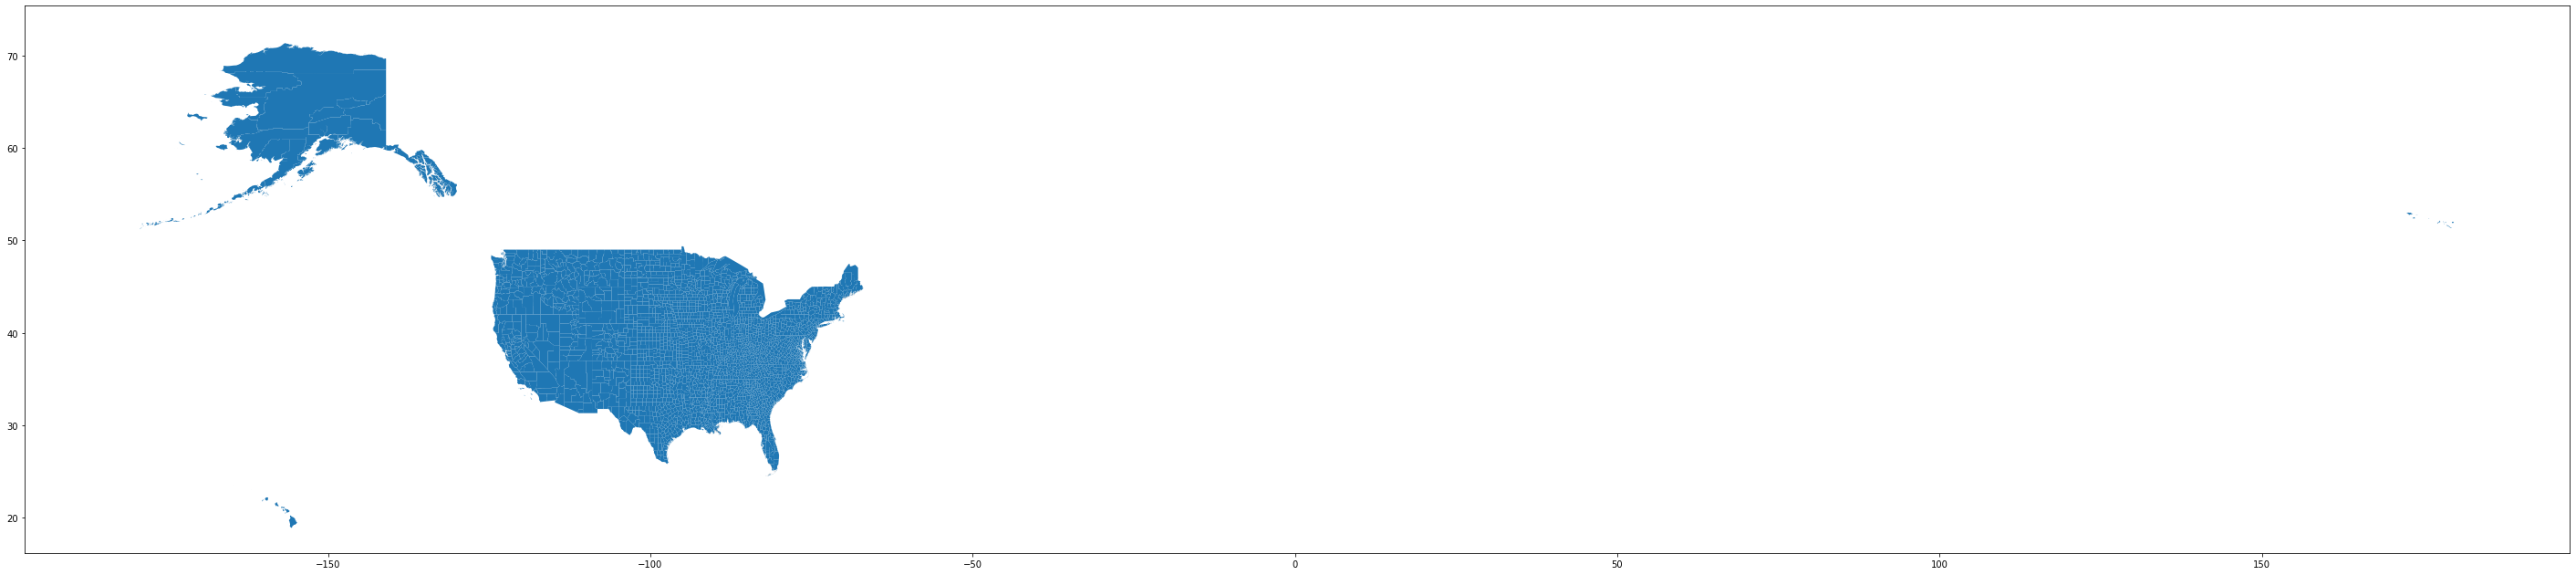

In [ ]:
counties.plot(figsize=(50, 50))

In [ ]:
counties.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,HASC_2,CCN_2,CCA_2,TYPE_2,ENGTYPE_2,NL_NAME_2,VARNAME_2,geometry
0,244,USA,United States,1,Alabama,1,Autauga,US.AL.AU,0,None,County,County,None,None,"POLYGON ((-86.91668 32.66431, -86.82678 32.660..."
1,244,USA,United States,1,Alabama,2,Baldwin,US.AL.BD,0,None,County,County,None,None,"MULTIPOLYGON (((-87.51056 30.33972, -87.51083 ..."
2,244,USA,United States,1,Alabama,3,Barbour,US.AL.BR,0,None,County,County,None,None,"POLYGON ((-85.13026 31.76386, -85.13504 31.768..."
3,244,USA,United States,1,Alabama,4,Bibb,US.AL.BI,0,None,County,County,None,None,"POLYGON ((-87.42078 32.87446, -87.42028 32.971..."
4,244,USA,United States,1,Alabama,5,Blount,US.AL.BU,0,None,County,County,None,None,"POLYGON ((-86.95322 33.81542, -86.95449 33.845..."


*Note* let's get rid of Alaska and Hawaii to simplify this example

In [ ]:
counties=(counties[(counties.NAME_1 != 'Alaska')&
                   (counties.NAME_1 != 'Hawaii')][
                  ['NAME_1','NAME_2','geometry']].reset_index(drop=True))

<AxesSubplot:>

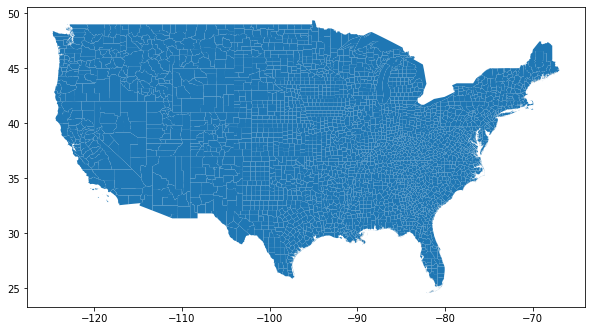

In [ ]:
counties.plot(figsize=(10,6))

### open up agricultural suitability

In [ ]:
suit=rio.open(suit_f)

In [3]:
f,ax=plt.subplots(figsize=(10, 6))
show(suit,ax=ax)

NameError: ignored

Let's have a look at the raster metadata

In [ ]:
suit.profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 720, 'height': 360, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.5, 0.0, -180.0,
       0.0, -0.5, 90.0), 'blockysize': 2, 'tiled': False, 'interleave': 'band'}

In [ ]:
suit.crs

CRS.from_epsg(4326)

read the raster data as an array / matrix

In [ ]:
array = suit.read(1)

Missing values are very large and negative for this raster -> need to fix

In [ ]:
array[array < 0] = np.nan

Let's see the distribution of agricultural suitability globally

In [4]:
f, ax = plt.subplots(1,1, figsize=(10, 6))
ax.hist(array[array != np.nan].reshape(-1,1), bins=30, edgecolor='k')
ax.set_xlabel('agricultural suitability')
ax.set_ylabel('frequency')
ax.grid(color='lightgray')
ax.set_axisbelow(True)
plt.show()

NameError: ignored

Let's crop the raster to the continental US. 

*Note*: we keep both the `array` that stores data values and the `transform` that relates the each row and column in the array to a coordinate

In [ ]:
suit_us_array, suit_us_transform = mask(suit, shapes=counties.geometry, crop=True, nodata=np.nan)

In [ ]:
suit_us_transform #check out the transform

Affine(0.5, 0.0, -125.0,
       0.0, -0.5, 49.5)

<AxesSubplot:>

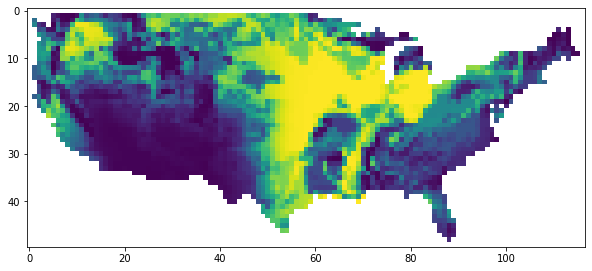

In [ ]:
f, ax = plt.subplots(figsize=(10, 6))
show(suit_us_array, ax=ax)

In [5]:
suit_us_array[0]

NameError: ignored

let's see the distribution again

In [6]:
f, ax = plt.subplots(1,1, figsize=(10, 6))
ax.hist(suit_us_array[suit_us_array != np.nan].reshape(-1,1), bins=30, edgecolor='k')
ax.set_xlabel('agricultural suitability')
ax.set_ylabel('frequency')
ax.grid(color='lightgray')
ax.set_axisbelow(True)
plt.show()

NameError: ignored

## Implement Zonal Statistics (now that we're set up)

Explanation of 'rasterization strategy' `all_touched`: https://pythonhosted.org/rasterstats/manual.html#rasterization-strategy

In [ ]:
zs1 = zonal_stats(counties, suit_us_array[0], affine=suit_us_transform, stats=['mean'], nodata=np.nan)    
zs2 = zonal_stats(counties, suit_us_array[0], affine=suit_us_transform, stats=['mean'], nodata=np.nan, all_touched=True)    
counties['mean_suit1'] = [x['mean'] for x in zs1]
counties['mean_suit2'] = [x['mean'] for x in zs2]

In [ ]:
counties

,NAME_1,NAME_2,geometry,mean_suit1,mean_suit2
0,Alabama,Autauga,"POLYGON ((-86.91668 32.66431, -86.82678 32.660...",NaN,0.270750
1,Alabama,Baldwin,"MULTIPOLYGON (((-87.51056 30.33972, -87.51083 ...",0.043000,0.093000
2,Alabama,Barbour,"POLYGON ((-85.13026 31.76386, -85.13504 31.768...",0.178000,0.260750
3,Alabama,Bibb,"POLYGON ((-87.42078 32.87446, -87.42028 32.971...",NaN,0.240750
4,Alabama,Blount,"POLYGON ((-86.95322 33.81542, -86.95449 33.845...",NaN,0.140250
...,...,...,...,...,...
3112,Wyoming,Sweetwater,"POLYGON ((-109.04901 41.00003, -109.08112 41.0...",0.169071,0.162250
3113,Wyoming,Teton,"POLYGON ((-111.04362 43.31358, -111.04391 43.4...",0.007200,0.063167
3114,Wyoming,Uinta,"POLYGON ((-110.04850 40.99883, -110.05729 40.9...",0.162500,0.181222
3115,Wyoming,Washakie,"POLYGON ((-107.10772 43.49963, -107.14559 43.4...",0.327500,0.312222


<AxesSubplot:>

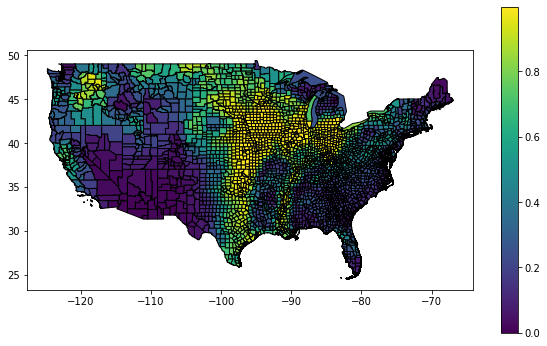

In [ ]:
counties.plot(column='mean_suit2', cmap='viridis', edgecolor='k', legend=True, figsize=(10, 6))